<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install igraph
!pip install biopython

# Código para generar grafos de PSN

In [24]:
# Sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi1": [1113, 1114, 1117, 1193, 1203, 1207, 1289, 1290, 1293, 1312, 1316], # datos de PDB. El indexado de los sitios no coincide con la distribución real de los mismos.
    "beta2AR_epi2": [109, 110, 113, 114, 117, 192, 193, 203, 204, 207, 289, 290, 293, 308, 309, 312],
    "beta2AR_epi3": [262, 263, 266, 342, 352, 356, 410, 411, 414, 433, 437], # sitios de unión de ligandos con numeración real.
    "beta2AR_G": [131, 134, 135, 136, 138, 139, 142, 222, 226, 229, 233, 236, 239, 271, 274] # solo tomamos los valores superiores a 0.5 (en PDB se recogen los valores).
    }

[array([-26.785,   4.701,  -7.207], dtype=float32), array([-26.153,   7.952,  -5.306], dtype=float32), array([-22.535,   7.626,  -6.501], dtype=float32), array([-23.812,   8.252, -10.048], dtype=float32), array([-26.502,  10.732,  -8.913], dtype=float32), array([-23.972,  13.029,  -7.195], dtype=float32), array([-21.478,  13.098, -10.092], dtype=float32), array([-24.434,  13.855, -12.379], dtype=float32), array([-25.375,  16.76 , -10.085], dtype=float32), array([-21.88 ,  18.277, -10.177], dtype=float32), array([-22.041,  18.524, -13.99 ], dtype=float32), array([-25.427,  20.271, -13.885], dtype=float32), array([-23.968,  22.982, -11.627], dtype=float32), array([-20.744,  23.21 , -13.666], dtype=float32), array([-22.781,  23.485, -16.89 ], dtype=float32), array([-25.014,  26.165, -15.346], dtype=float32), array([-22.045,  28.143, -13.951], dtype=float32), array([-19.882,  28.071, -17.094], dtype=float32), array([-22.755,  28.909, -19.443], dtype=float32), array([-24.305,  31.615, -17.2

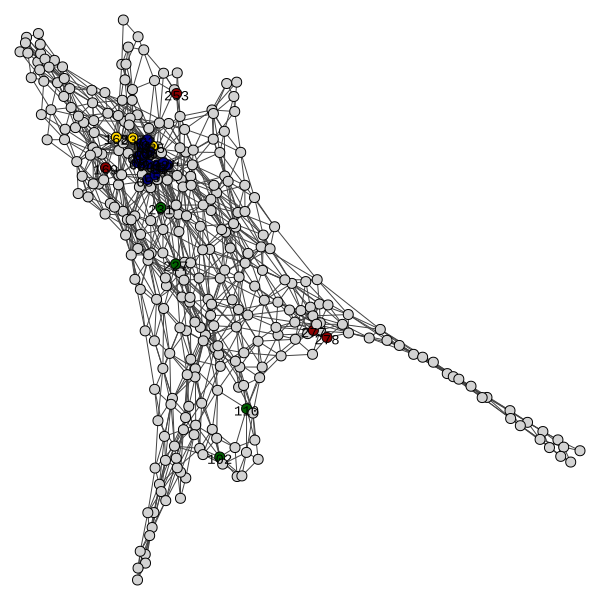

In [41]:
# Versión más nueva: usando CKDTree para calcular distancias y graficar el grafo.
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

pdb_id = "2ydo"

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# Extracción de los CA en una lista

CA_coord = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                if atom.get_name() == "CA":
                   CA_coord.append(atom.get_coord())

# Extracción de las coordenadas del ligando

alig_list = []
alig_coord = []

for model in structure:
    for chain in model:
        if chain.id != "A":
            continue
        for residue in chain:
            if residue.get_resname() == "ADN" and residue.id[1] == 400:
                for atom in residue:
                    alig_list.append(atom.get_id())
                    alig_coord.append(atom.get_coord())
                    # print(residue.get_resname(), residue.id) # debug print

# Generamos un conjunto con los elementos de alig_coord y de CA_coord

atom_coord = []
for acoord in CA_coord:
  atom_coord.append(acoord)
for acoord in alig_coord:
  atom_coord.append(acoord)

# Generación del árbol (cKDTree) y generación de pares de átomos

tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10) # permite regular el radio de la esfera
# de distancia

r_min = 5
r_max = 8

# Filtrar solo los que están entre r_min y r_max
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))


# Cálculo de los caminos más cortos (shortest pathways)

shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

# Generación del grafo

g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 10
g.vs["color"] = ["lightgray"]

# Colorear los nodos de los sitios de interés
for aa in sites["A2A_adenosine"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = aa

for aa in sites["A2A_G"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = aa

# Colorear los nodos del ligando en azul oscuro
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)

for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]  # Opcional, puede ser atom ID


# === Cálculo de caminos más cortos ===
shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

if shortest_path:
    for node in shortest_path:
        g.vs[node]["color"] = "gold"
        g.vs[node]["label"] = str(node)

layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout)


# site_nodes = sites["A2A_adenosine"] + sites["A2A_G"]
# subg = g.subgraph(site_nodes)
# ig.plot(subg)



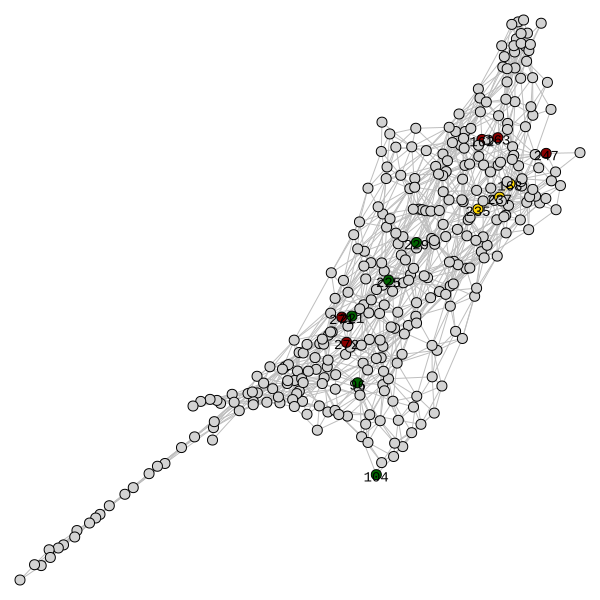

In [19]:
# Cálculo del grafo usando centroides en vez del carbono alfa
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

pdb_id = "2ydo"

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CENTROIDES por residuo ===
centroid_coords = []
residue_indices = []  # Lista para almacenar los índices de los residuos

for model in structure:
    for chain in model:
        for residue_index, residue in enumerate(chain):  # 'residue_index' nos da el índice
            atom_coords = []
            for atom in residue.get_atoms():
                if atom.element != 'H':  # Excluye hidrógenos
                    atom_coords.append(atom.get_coord())
            if atom_coords:
                centroid = np.mean(atom_coords, axis=0)
                centroid_coords.append(centroid)
                residue_indices.append((residue.get_resname(), residue.get_id()[1], centroid))  # Guardamos el nombre y ID del residuo junto con el centroide

# Mostrar los residuos con sus centroides y sus índices
# print("Residuos y sus centroides:")
# for idx, (res_name, res_id, centroid) in enumerate(residue_indices):
#     print(f"Índice: {idx}, Residuo: {res_name} {res_id}, Centroide: {centroid}")


# === Extracción de coordenadas del ligando ===
alig_list = []
alig_coord = []

# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())

# === Construcción del conjunto total de coordenadas ===
atom_coord = centroid_coords + alig_coord

# === Construcción del árbol cKDTree y obtención de pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 5
r_max = 8

atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Construcción del grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 10
g.vs["color"] = ["lightgray"]
g.es["color"] = "gray"

# === Coloreado de sitios ===
# Asignar un "offset" para corregir el desplazamiento
offset = 6  # Ajustamos el índice al residuo PHE 168

# Colorear los nodos de los sitios de interés
for aa in sites["A2A_adenosine"]:
    aa_corrected = aa - offset  # Ajustamos el índice
    if 0 <= aa_corrected < len(g.vs):
        g.vs[aa_corrected]["color"] = "darkred"
        g.vs[aa_corrected]["label"] = aa_corrected

for aa in sites["A2A_G"]:
    aa_corrected = aa - offset  # Ajustamos el índice
    if 0 <= aa_corrected < len(g.vs):
        g.vs[aa_corrected]["color"] = "darkgreen"
        g.vs[aa_corrected]["label"] = aa_corrected

# Colorear los nodos del ligando en azul oscuro
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)

for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]  # Opcional, puede ser atom ID


# === Cálculo de caminos más cortos ===
shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

if shortest_path:
    for node in shortest_path:
        g.vs[node]["color"] = "gold"
        g.vs[node]["label"] = str(node)
    for i in range(len(shortest_path) - 1):
        source = shortest_path[i]
        target = shortest_path[i + 1]
        eid = g.get_eid(source, target)
        g.es[eid]["color"] = "gold"

# == colorear las aristas ==


layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout)

In [16]:
# Buscar el residuo Phe168 en la estructura y verificar su índice
residue_name = "PHE"
residue_id = 168
found_residue = False

for model in structure:
    for chain in model:
        for residue_index, residue in enumerate(chain):
            if residue.get_resname() == residue_name and residue.get_id()[1] == residue_id:
                found_residue = True
                print(f"Residuo {residue_name} {residue_id} encontrado en la cadena {chain.id} en el índice {residue_index}")
                # Puedes imprimir el centroide para verificarlo también
                atom_coords = [atom.get_coord() for atom in residue.get_atoms() if atom.element != 'H']
                centroid = np.mean(atom_coords, axis=0)
                print(f"Centroide de PHE 168: {centroid}")
                break
    if found_residue:
        break

if not found_residue:
    print(f"El residuo {residue_name} {residue_id} no se encuentra en la estructura.")

from collections import Counter

color_count = Counter(g.vs["color"])
print("Conteo de colores en el grafo:")
print(color_count)


Residuo PHE 168 encontrado en la cadena A en el índice 162
Centroide de PHE 168: [-34.211094   5.885454 -21.998363]
Conteo de colores en el grafo:
Counter({'lightgray': 316, 'darkgreen': 5, 'darkred': 5, 'gold': 4})


In [20]:
for idx in sites["A2A_adenosine"]:
    print(f"Índice: {idx}, Nodo: {g.vs[idx]['label']}, Color: {g.vs[idx]['color']}")


Índice: 168, Nodo: 168, Color: gold
Índice: 169, Nodo: None, Color: lightgray
Índice: 253, Nodo: None, Color: lightgray
Índice: 277, Nodo: None, Color: lightgray
Índice: 278, Nodo: None, Color: lightgray
